In [1]:
import pandas as pd

df_btc = pd.read_csv("../data/quotes_BTC.csv")
df_btc["timestamp"] = df_btc["timestamp"].apply(lambda x: x[:10])
print(df_btc["timestamp"])
df_btc = df_btc.astype({"timestamp": "datetime64[s]"}).set_index("timestamp")
df_btc.head()

0     2024-08-21
1     2024-08-22
2     2024-08-23
3     2024-08-24
4     2024-08-25
         ...    
95    2024-11-24
96    2024-11-25
97    2024-11-26
98    2024-11-27
99    2024-11-28
Name: timestamp, Length: 100, dtype: object


,Unnamed: 0,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,price,volume_24h,market_cap,total_supply,circulating_supply
timestamp,,,,,,,,,,
2024-08-21,0,-0.259023,3.119146,3.822595,-9.291341,61220.255035,3.230223e+10,1.208683e+12,19743196,19743196
2024-08-22,1,-0.366595,-1.457215,4.719244,-8.518946,60328.144488,2.804668e+10,1.191099e+12,19743678,19743678
2024-08-23,2,-0.392219,6.412008,9.026376,-1.725949,64196.389701,4.164920e+10,1.267505e+12,19744178,19744178
2024-08-24,3,0.416369,-0.385213,7.679103,-2.732526,63949.097035,2.225770e+10,1.262655e+12,19744696,19744696
2024-08-25,4,0.251679,1.101118,8.943554,-4.825128,64653.252252,1.750459e+10,1.276586e+12,19745112,19745112


In [ ]:
import numpy as np

series = df_btc['price']
min = np.min(series)
max = np.max(series)
series -= min
series /= max


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
    
    def __len__(self):
        return len(self.data) - self.window_size
    
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.window_size]
        y = self.data[idx+self.window_size]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
window_size = 10
dataset = TimeSeriesDataset(series, window_size)

# Split into train and test sets
train_size = int(len(dataset) * 0.8)

train_dataset = torch.utils.data.Subset(dataset, range(train_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Build model

import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        _, (hn, _) = self.lstm(x)  # Get the last hidden state
        out = self.fc(hn[-1])  # Pass the last hidden state through the fully connected layer
        return out
    

input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
print(model)

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
# Train model

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X, y in train_loader:
        X = X.unsqueeze(-1)  # Add feature dimension (batch, sequence, feature)
        y = y.unsqueeze(-1)  # Add feature dimension

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")

/var/folders/pw/6x12jmwn6dx_wqvppt7_zpxw0000gn/T/ipykernel_75934/1067399264.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = self.data[idx+self.window_size]
/var/folders/pw/6x12jmwn6dx_wqvppt7_zpxw0000gn/T/ipykernel_75934/1067399264.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


Epoch [1/100], Loss: 0.0060
Epoch [2/100], Loss: 0.0064
Epoch [3/100], Loss: 0.0048
Epoch [4/100], Loss: 0.0046
Epoch [5/100], Loss: 0.0049
Epoch [6/100], Loss: 0.0049
Epoch [7/100], Loss: 0.0048
Epoch [8/100], Loss: 0.0046
Epoch [9/100], Loss: 0.0044
Epoch [10/100], Loss: 0.0044
Epoch [11/100], Loss: 0.0043
Epoch [12/100], Loss: 0.0042
Epoch [13/100], Loss: 0.0038
Epoch [14/100], Loss: 0.0028
Epoch [15/100], Loss: 0.0031
Epoch [16/100], Loss: 0.0183
Epoch [17/100], Loss: 0.0088
Epoch [18/100], Loss: 0.0064
Epoch [19/100], Loss: 0.0037
Epoch [20/100], Loss: 0.0047
Epoch [21/100], Loss: 0.0057
Epoch [22/100], Loss: 0.0052
Epoch [23/100], Loss: 0.0049
Epoch [24/100], Loss: 0.0047
Epoch [25/100], Loss: 0.0045
Epoch [26/100], Loss: 0.0043
Epoch [27/100], Loss: 0.0043
Epoch [28/100], Loss: 0.0044
Epoch [29/100], Loss: 0.0044
Epoch [30/100], Loss: 0.0044
Epoch [31/100], Loss: 0.0043
Epoch [32/100], Loss: 0.0041
Epoch [33/100], Loss: 0.0038
Epoch [34/100], Loss: 0.0036
Epoch [35/100], Loss: 0

/var/folders/pw/6x12jmwn6dx_wqvppt7_zpxw0000gn/T/ipykernel_75934/1067399264.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = self.data[idx+self.window_size]
/var/folders/pw/6x12jmwn6dx_wqvppt7_zpxw0000gn/T/ipykernel_75934/1067399264.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


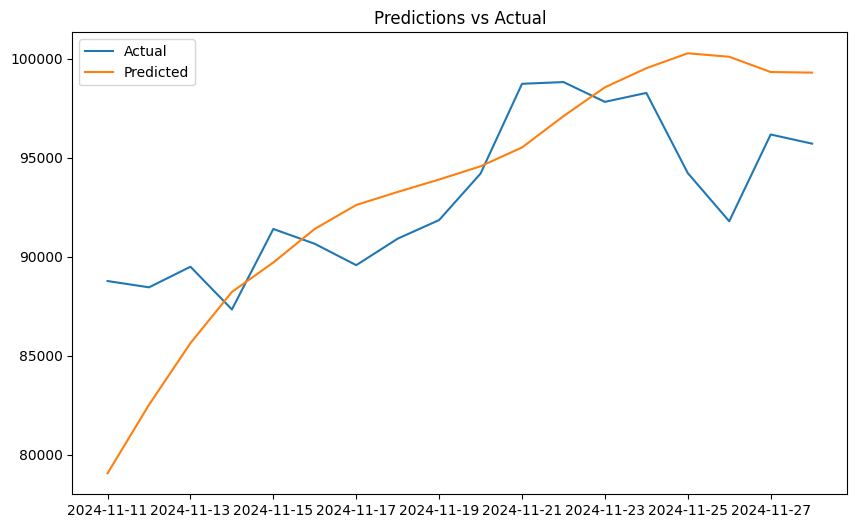

In [ ]:
# Evaluate results

import matplotlib.pyplot as plt

model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X, y in test_loader:
        X = X.unsqueeze(-1)  # Add feature dimension
        outputs = model(X)
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(y.tolist())

plt.figure(figsize=(10, 6))

scaled_xvalid=np.array(actuals)*max
scaled_xvalid=scaled_xvalid+min
scaled_forecast=np.array(predictions)*max
scaled_forecast=scaled_forecast+min
time_valid = df_btc.index[train_size + window_size:]

plt.plot(time_valid, scaled_xvalid, label="Actual")
plt.plot(time_valid, scaled_forecast, label="Predicted")
plt.legend()
plt.title("Predictions vs Actual")
plt.show()